#### Model: 

\begin{eqnarray}
X_t & = & A X_{t-1} + \nu_t,
\\
Y_t & = & C X_t + \omega_t,
\\
\nu_t & \sim & \text{N}(0, Q ) ~~ \text{with} ~ Q = \sigma_x^2 I,
\\
\omega_t & \sim & \text{N}(0, R) ~~ \text{with} ~ R = \sigma_y^2 I.
\end{eqnarray}

In [1]:
from __future__ import division
%matplotlib inline
from pykalman import KalmanFilter
import numpy as np, numpy.random as npr, matplotlib.pyplot as plt, copy, multiprocessing as mp
from scipy.stats import *
from pylab import plot, show, legend
from tqdm import trange
from functions_linear_gaussian_HMM import *

In [2]:
A = np.asarray([[0.9, -0.3], 
                [0.2, 1]])
C = np.asarray([[-1.1, 0.5],
                [-0.3, 0.8]])
dim = np.shape(A)[0]
sigmax2 = 5e-1
sigmay2 = 5e-1
Q = sigmax2*np.eye(dim)
R = sigmay2*np.eye(dim)
mu0 = np.zeros(dim)
Sigma0 = np.eye(dim)

In [38]:
T = 1_000
Y, X = generate_data_linear_gaussian(mu0, Sigma0, A, C, Q, R, T)

#### Sanity check:

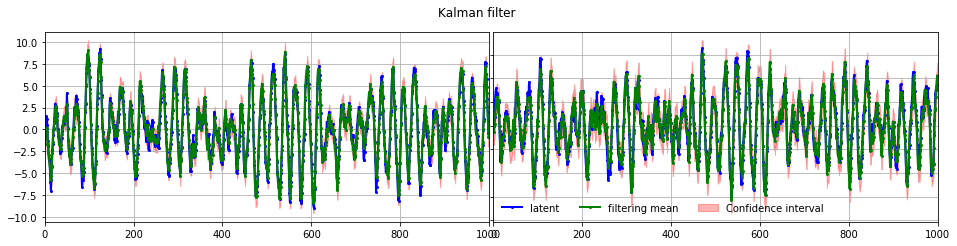

In [39]:
kf = KalmanFilter(initial_state_mean=mu0,
                  initial_state_covariance=Sigma0,
                  transition_matrices=A, 
                  observation_matrices=C, 
                  transition_covariance=Q, 
                  observation_covariance=R)
(filtered_state_means, filtered_state_covariances) = kf.filter(Y)

plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(X[:,i], "bo-", label="latent", markersize=2, linewidth=2)
    plt.plot(filtered_state_means[:,i], "go-", label="filtering mean", markersize=2, linewidth=2)
    plt.fill_between(np.arange(T), 
                     filtered_state_means[:,i] + 2*np.sqrt(filtered_state_covariances[:,i,i]), 
                     filtered_state_means[:,i] - 2*np.sqrt(filtered_state_covariances[:,i,i]), 
                     color='red', alpha=0.3, label="Confidence interval")
    if i == 1 : plt.yticks(alpha=0)
    plt.grid(True)
    plt.xlim(0,T)
plt.legend(ncol=3, frameon=False)
plt.suptitle("Kalman filter")
plt.subplots_adjust(wspace=1e-2)
plt.xlim(0,T)
plt.show()

### MCMC on full data:

In [12]:
n_mcmc = 10_000
scale = [0.2, 0.1]

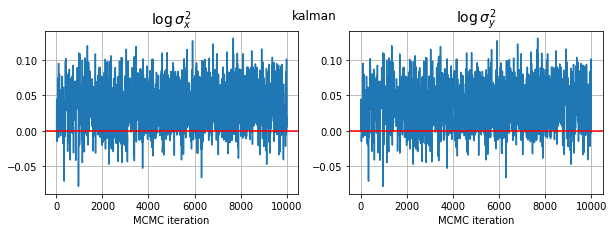

In [7]:
power = 1
log_sigmay2_chain_full, log_sigmax2_chain_full, accepted_full, scales_full \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, 
              scale=scale, power=power, method="kalman", adapt=True, kappa=2)

plot(log_sigmay2_chain_full, log_sigmay2_chain_full, sigmax2, sigmay2, "kalman")

### Divide-and-conquer:

In [41]:
m = 10
K = int(T/m)
tstarts = K*np.arange(m).astype(int)
Ychunks = [Y[tstart:(K+tstart)] for tstart in tstarts]

scale = np.asarray([0.3, 0.3])

In [42]:
def f(y) :
    return adaptive_MH(y, A, C, sigmax2, sigmay2, mu0, Sigma0, 1000, 
                       scale=scale/K, power=K, method="kalman", adapt=True, kappa=2)

In [36]:
pool = mp.Pool(m)
results = pool.map(f, [y for y in Ychunks])
pool.close()

100%|██████████| 1000/1000 [08:45<00:00,  2.02it/s]


14.3 % acceptance rate


100%|██████████| 1000/1000 [08:50<00:00,  1.68it/s]


13.5 % acceptance rate


100%|██████████| 1000/1000 [08:50<00:00,  2.47it/s]


13.3 % acceptance rate


100%|██████████| 1000/1000 [08:50<00:00,  2.20it/s]


16.8 % acceptance rate


100%|██████████| 1000/1000 [08:52<00:00,  2.86it/s]


15.6 % acceptance rate


100%|██████████| 1000/1000 [08:52<00:00,  2.67it/s]


14.0 % acceptance rate


100%|██████████| 1000/1000 [08:54<00:00,  3.22it/s]


15.0 % acceptance rate


100%|█████████▉| 996/1000 [08:55<00:01,  3.35it/s]]


14.1 % acceptance rate


100%|██████████| 1000/1000 [08:56<00:00,  3.48it/s]


14.5 % acceptance rate


100%|██████████| 1000/1000 [08:59<00:00,  3.48it/s]


14.9 % acceptance rate


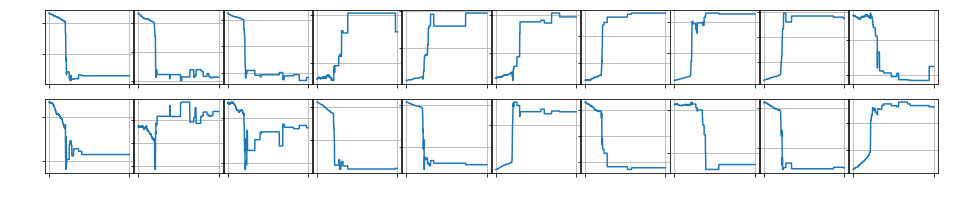

In [37]:
plt.rcParams['figure.figsize'] = (16, 3)
for i in range(m) :
    plt.subplot(2,m,i+1)
    plt.plot(results[i][0])
    plt.grid(True)
    plt.xticks(alpha=0)
    plt.yticks(alpha=0)
    
    plt.subplot(2,m,m+1+i)
    plt.plot(results[i][1])
    plt.grid(True)
    plt.xticks(alpha=0)
    plt.yticks(alpha=0)
plt.subplots_adjust(wspace=1e-2)